# 적용 예정 모델

- Linear Regression
- RandomForestRegressor
- XGBoost Regressor
- SVR
- KNN Regressor

### Branch
1. BaseLine
2. RUL_Clipping
3. Scaling(Standard, MinMax, Robust)
4. 하이퍼 파라미터 튜닝

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# 한글 인코딩 문제 해결
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows

In [2]:
train = pd.read_csv(r'C:\Users\ASUS\.cache\kagglehub\datasets\behrad3d\nasa-cmaps\versions\1\CMaps\train_FD004.txt', sep=' ', header=None)
test = pd.read_csv(r'C:\Users\ASUS\.cache\kagglehub\datasets\behrad3d\nasa-cmaps\versions\1\CMaps\test_FD004.txt', sep=' ', header=None)
RUL = pd.read_csv(r'C:\Users\ASUS\.cache\kagglehub\datasets\behrad3d\nasa-cmaps\versions\1\CMaps\RUL_FD004.txt', sep=' ', header=None)
train.drop(columns=[26, 27], inplace=True)
test.drop(columns=[26, 27], inplace=True)
RUL.drop(columns=[1], inplace=True)

col_names = ['unit', 'cycle', 'setting_1', 'setting_2', 'setting_3', 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
train.columns = col_names
test.columns = col_names
RUL.columns = ['RUL']

In [3]:
# RUL 구하기
def get_RUL(df):
    rul_list = [x for x in df.groupby('unit')['cycle'].max()]
    for unit in df['unit'].unique():
        df.loc[df['unit']==unit, 'RUL'] = rul_list[unit-1] - df.loc[df['unit']==unit, 'cycle']

get_RUL(train)

In [4]:
train

,unit,cycle,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320.0
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319.0
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318.0
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317.0
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,2388.73,8185.69,8.4541,0.03,372,2319,100.00,29.11,17.5234,4.0
61245,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,2388.46,8185.47,8.2221,0.03,396,2388,100.00,39.38,23.7151,3.0
61246,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,2388.48,8193.94,8.2525,0.03,395,2388,100.00,39.78,23.8270,2.0
61247,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,2388.83,8125.64,9.0515,0.02,337,2223,100.00,15.26,9.0774,1.0


- 전처리 1 : 제외할 만한 변동이 없는 컬럼 찾기

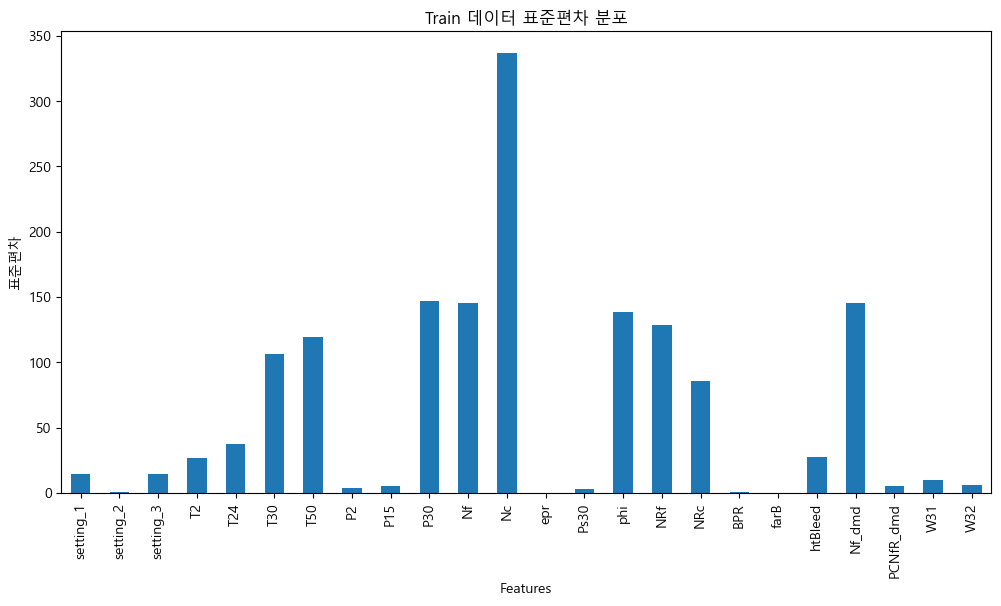

In [5]:
# 표준편차 분포로 제외할 만한 컬럼 찾기
plt.figure(figsize=(12,6))
std = train.drop(columns=['unit', 'cycle', 'RUL']).std()
std.plot(kind='bar')
plt.title('Train 데이터 표준편차 분포')
plt.xlabel('Features')
plt.ylabel('표준편차')
plt.show()

In [6]:
# 21가지 센서를 모두 적용하겠습니다.
features = train.columns[5:-1]
features

Index(['T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr',
       'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd',
       'PCNfR_dmd', 'W31', 'W32'],
      dtype='object')

---

In [7]:
# 시계열성을 따지지 않으므로 테스트셋의 마지막 사이클만 가져오기
test

,unit,cycle,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,313.03,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,163.61,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,129.98,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,129.48,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,181.82,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41209,248,277,41.9991,0.8401,100.0,445.00,550.30,1364.40,1129.17,3.91,...,130.87,2388.50,8112.61,9.4427,0.02,331,2212,100.00,10.53,6.2620
41210,248,278,20.0026,0.7005,100.0,491.19,608.00,1494.75,1260.88,9.35,...,314.51,2388.33,8086.83,9.2772,0.02,366,2324,100.00,24.33,14.6486
41211,248,279,34.9988,0.8413,100.0,449.44,555.92,1370.65,1130.97,5.48,...,182.76,2388.64,8100.84,9.3982,0.02,336,2223,100.00,14.69,8.8389
41212,248,280,20.0027,0.7000,100.0,491.19,608.19,1489.11,1256.25,9.35,...,314.17,2388.37,8085.24,9.2727,0.03,366,2324,100.00,24.44,14.6887


In [8]:
test.loc[test['unit'].isin(test['unit'].unique())].groupby('unit').last()[features].reset_index().drop(columns=['unit'])

,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,462.54,537.66,1264.31,1046.41,7.05,8.99,176.56,1915.66,8023.10,0.94,...,166.19,2028.53,7890.31,10.7615,0.02,308,1915,84.93,14.41,8.6329
1,445.00,549.96,1354.05,1133.55,3.91,5.72,139.03,2211.69,8310.36,1.02,...,130.17,2387.72,8073.44,9.3925,0.02,331,2212,100.00,10.58,6.4325
2,445.00,549.47,1341.06,1118.90,3.91,5.69,139.26,2212.04,8331.13,1.02,...,130.73,2388.18,8095.58,9.2974,0.02,330,2212,100.00,10.61,6.3488
3,462.54,536.06,1253.49,1038.53,7.05,9.00,175.63,1915.39,8012.46,0.94,...,164.91,2028.30,7878.63,10.8396,0.02,306,1915,84.93,14.41,8.5696
4,462.54,537.36,1263.60,1052.52,7.05,9.03,175.53,1915.36,8011.76,0.94,...,164.95,2028.24,7873.75,10.9094,0.02,307,1915,84.93,14.19,8.6248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,491.19,607.94,1488.25,1255.52,9.35,13.66,334.72,2324.21,8761.89,1.08,...,314.85,2388.39,8094.02,9.2557,0.02,364,2324,100.00,24.42,14.5261
244,491.19,606.61,1481.48,1238.30,9.35,13.65,336.64,2323.93,8726.74,1.08,...,315.99,2388.03,8066.79,9.1421,0.02,363,2324,100.00,24.70,14.8356
245,491.19,606.82,1483.01,1241.32,9.35,13.65,334.86,2323.90,8722.26,1.08,...,315.22,2388.02,8060.86,9.1768,0.02,364,2324,100.00,24.70,14.7371
246,462.54,536.91,1261.67,1052.33,7.05,9.03,175.84,1915.31,8006.63,0.94,...,164.60,2028.24,7878.48,10.9332,0.02,307,1915,84.93,14.21,8.4721


In [9]:
X_train = train[features]
y_train = train['RUL']
X_test = test.loc[test['unit'].isin(test['unit'].unique())].groupby('unit').last()[features].reset_index().drop(columns=['unit'])[features]
y_test = RUL

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(61249, 21) (61249,)
(248, 21) (248, 1)


1. 베이스라인

- 모델 적용해보기 (Random Forest, LinearRegression)

In [10]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [11]:
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

In [12]:
# 모델 정의
models1 = {
    'Linear Regression' : LinearRegression(n_jobs=-1),
    'Random Forest' : RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost' : XGBRegressor(random_State=42, n_jobs=-1),
    'SVR' : SVR(kernel='rbf'),
    'KNN' : KNeighborsRegressor(n_jobs=-1)
}

# 결과 저장 리스트
results1 = []

print("===베이스라인 모델===")

# 학습 실행

for name, model in models1.items():
    model.fit(X_train, y_train)

    pred = model.predict(X_test)

    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    # 결과 저장
    results1.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2 Score': r2
    })

    print(f'{name} 완료, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2 Score: {r2:.4f}')

# 결과 표 출력
baseline_df = pd.DataFrame(results1).set_index('Model')
baseline_df = baseline_df.sort_values(by='RMSE', ascending=True).round(4)

print("\n===모델 성능 비교===")
print(baseline_df)

===베이스라인 모델===
Linear Regression 완료, RMSE: 47.6456, MAE: 38.5324, R2 Score: 0.2364
Random Forest 완료, RMSE: 43.2569, MAE: 31.5816, R2 Score: 0.3706


c:\Users\ASUS\anaconda3\envs\ds_study\lib\site-packages\xgboost\core.py:158: UserWarning: [12:13:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "random_State" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost 완료, RMSE: 42.0864, MAE: 30.3634, R2 Score: 0.4042
SVR 완료, RMSE: 65.2739, MAE: 54.6491, R2 Score: -0.4332
KNN 완료, RMSE: 53.0159, MAE: 38.3355, R2 Score: 0.0545

===모델 성능 비교===
                      RMSE      MAE  R2 Score
Model                                        
XGBoost            42.0864  30.3634    0.4042
Random Forest      43.2569  31.5816    0.3706
Linear Regression  47.6456  38.5324    0.2364
KNN                53.0159  38.3355    0.0545
SVR                65.2739  54.6491   -0.4332


---

- RUL Clipping

In [13]:
# y_train셋의 RUL 값을 120, 125, 130으로 클리핑하여 성능 비교
y_train_clipped_120 = y_train.clip(upper=120)
y_train_clipped_125 = y_train.clip(upper=125)
y_train_clipped_130 = y_train.clip(upper=130)

In [14]:
clip_list = [y_train_clipped_120, y_train_clipped_125, y_train_clipped_130]

In [15]:
# 모델 정의
models2 = {
    'Linear Regression' : LinearRegression(n_jobs=-1),
    'Random Forest' : RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost' : XGBRegressor(random_state=42, n_jobs=-1),
    'SVR' : SVR(kernel='rbf'),
    'KNN' : KNeighborsRegressor(n_jobs=-1)
}

# 학습 실행

for clip in clip_list:
    y_train = clip
    # 결과 저장 리스트
    results = []
    print(f"--- {clip.max()} ---")
    for name, model in models2.items():
        model.fit(X_train, y_train)

        pred = model.predict(X_test)

        mse = mean_squared_error(y_test, pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, pred)
        r2 = r2_score(y_test, pred)

        # 결과 저장
        results.append({
            'Model': name,
            'RMSE': rmse,
            'MAE': mae,
            'R2 Score': r2
        })

        print(f'{name} 완료, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2 Score: {r2:.4f}')

    # 결과 표 출력
    df = pd.DataFrame(results).set_index('Model')
    df = df.sort_values(by='RMSE', ascending=True).round(4)

    print("\n===모델 성능 비교===")
    print(df)

--- 120.0 ---
Linear Regression 완료, RMSE: 35.3106, MAE: 28.0560, R2 Score: 0.5806
Random Forest 완료, RMSE: 31.2052, MAE: 23.0874, R2 Score: 0.6724


c:\Users\ASUS\anaconda3\envs\ds_study\lib\site-packages\xgboost\core.py:158: UserWarning: [12:19:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "random_State" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost 완료, RMSE: 31.3775, MAE: 23.2908, R2 Score: 0.6688
SVR 완료, RMSE: 63.6685, MAE: 53.4027, R2 Score: -0.3636
KNN 완료, RMSE: 33.4636, MAE: 25.6887, R2 Score: 0.6233

===모델 성능 비교===
                      RMSE      MAE  R2 Score
Model                                        
Random Forest      31.2052  23.0874    0.6724
XGBoost            31.3775  23.2908    0.6688
KNN                33.4636  25.6887    0.6233
Linear Regression  35.3106  28.0560    0.5806
SVR                63.6685  53.4027   -0.3636
--- 125.0 ---
Linear Regression 완료, RMSE: 34.5615, MAE: 27.7461, R2 Score: 0.5982
Random Forest 완료, RMSE: 30.2048, MAE: 22.6563, R2 Score: 0.6931


c:\Users\ASUS\anaconda3\envs\ds_study\lib\site-packages\xgboost\core.py:158: UserWarning: [12:26:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "random_State" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost 완료, RMSE: 30.2144, MAE: 22.7660, R2 Score: 0.6929
SVR 완료, RMSE: 65.2322, MAE: 54.6174, R2 Score: -0.4314
KNN 완료, RMSE: 32.8574, MAE: 25.3524, R2 Score: 0.6368

===모델 성능 비교===
                      RMSE      MAE  R2 Score
Model                                        
Random Forest      30.2048  22.6563    0.6931
XGBoost            30.2144  22.7660    0.6929
KNN                32.8574  25.3524    0.6368
Linear Regression  34.5615  27.7461    0.5982
SVR                65.2322  54.6174   -0.4314
--- 130.0 ---
Linear Regression 완료, RMSE: 34.0003, MAE: 27.5513, R2 Score: 0.6111
Random Forest 완료, RMSE: 29.2692, MAE: 22.2453, R2 Score: 0.7118


c:\Users\ASUS\anaconda3\envs\ds_study\lib\site-packages\xgboost\core.py:158: UserWarning: [12:33:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "random_State" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost 완료, RMSE: 29.5089, MAE: 21.8985, R2 Score: 0.7071
SVR 완료, RMSE: 65.2739, MAE: 54.6491, R2 Score: -0.4332
KNN 완료, RMSE: 32.4687, MAE: 25.1766, R2 Score: 0.6454

===모델 성능 비교===
                      RMSE      MAE  R2 Score
Model                                        
Random Forest      29.2692  22.2453    0.7118
XGBoost            29.5089  21.8985    0.7071
KNN                32.4687  25.1766    0.6454
Linear Regression  34.0003  27.5513    0.6111
SVR                65.2739  54.6491   -0.4332


---

- 스케일링 적용
    - RUL_Clipping : 125

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# 적용할 스케일러
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# 모델 정의
models3 = {
    'Linear Regression': LinearRegression(n_jobs=-1),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(random_state=42, n_jobs=-1),
    'SVR': SVR(kernel='rbf'),
    'KNN': KNeighborsRegressor(n_jobs=-1)
}

results3 = []

# 첫 번째 루프: 스케일러 적용
for scaler_name, scaler in scalers.items():
    print(f"--- [Scaling: {scaler_name}] ---")
    
    # 스케일링 수행 (Data Leakage 방지를 위해 Train으로 fit 후 Transform)
    # X_train, X_test 변수가 이미 정의되어 있다고 가정합니다.
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 두 번째 루프: 모델 학습 및 평가
    for model_name, model in models3.items():
        
        # 학습
        model.fit(X_train_scaled, y_train_clipped_125)
        
        # 예측
        pred = model.predict(X_test_scaled)
        
        # 평가
        mse = mean_squared_error(y_test, pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        
        # 결과 저장 (어떤 스케일러인지 함께 기록)
        results3.append({
            'Scaler': scaler_name,
            'Model': model_name,
            'RMSE': rmse,
            'MAE': mae,
            'R2 Score': r2
        })
        
        print(f"   ✅ {model_name} 완료 (RMSE: {rmse:.4f})")
    print("") # 줄바꿈

# 4. 결과 표 출력
scaled_df = pd.DataFrame(results3)

# RMSE 기준으로 오름차순 정렬 (성능 좋은 순서대로 보기)
scaled_df = scaled_df.sort_values(by='RMSE', ascending=True).round(4)

print("\n" + "="*50)
print("🏆 최종 성능 비교표 (Top 10)")
print("="*50)
display(scaled_df)

--- [Scaling: StandardScaler] ---
   ✅ Linear Regression 완료 (RMSE: 34.5615)
   ✅ Random Forest 완료 (RMSE: 30.2264)
   ✅ XGBoost 완료 (RMSE: 30.2144)
   ✅ SVR 완료 (RMSE: 45.6118)
   ✅ KNN 완료 (RMSE: 32.2610)

--- [Scaling: MinMaxScaler] ---
   ✅ Linear Regression 완료 (RMSE: 34.5615)
   ✅ Random Forest 완료 (RMSE: 30.2253)
   ✅ XGBoost 완료 (RMSE: 30.2144)
   ✅ SVR 완료 (RMSE: 48.8717)
   ✅ KNN 완료 (RMSE: 32.6754)

--- [Scaling: RobustScaler] ---
   ✅ Linear Regression 완료 (RMSE: 34.5615)
   ✅ Random Forest 완료 (RMSE: 30.2344)
   ✅ XGBoost 완료 (RMSE: 30.2144)
   ✅ SVR 완료 (RMSE: 65.3266)
   ✅ KNN 완료 (RMSE: 32.0418)


🏆 최종 성능 비교표 (Top 10)


,Scaler,Model,RMSE,MAE,R2 Score
2,StandardScaler,XGBoost,30.2144,22.7660,0.6929
7,MinMaxScaler,XGBoost,30.2144,22.7660,0.6929
12,RobustScaler,XGBoost,30.2144,22.7660,0.6929
6,MinMaxScaler,Random Forest,30.2253,22.6852,0.6927
1,StandardScaler,Random Forest,30.2264,22.6848,0.6927
11,RobustScaler,Random Forest,30.2344,22.7035,0.6925
14,RobustScaler,KNN,32.0418,24.0879,0.6546
4,StandardScaler,KNN,32.2610,24.7952,0.6499
9,MinMaxScaler,KNN,32.6754,25.0153,0.6409
0,StandardScaler,Linear Regression,34.5615,27.7461,0.5982
